<a href="https://colab.research.google.com/github/NCChacki/DS2500-DataWrangling/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install spotipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.0/252.0 kB 3.6 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.feature_selection import chi2
import seaborn as sb
import math

from bs4 import BeautifulSoup


import spotipy
import pandas as pd
import matplotlib.pyplot as plt
from spotipy.oauth2 import SpotifyClientCredentials
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.feature_selection import chi2
import base64
from types import CoroutineType
from requests.api import request
import matplotlib.colors as mcolors
from google.colab import userdata

In [22]:
import requests
# reference curl for requesting access token
# curl -X POST "https://accounts.spotify.com/api/token" \
#      -H "Content-Type: application/x-www-form-urlencoded" \
#      -d "grant_type=client_credentials&client_id=your-client-id&client_secret=your-client-secret"

url = "https://accounts.spotify.com/api/token"

api_call_data = {
    'grant_type':'client_credentials',
    'client_id': userdata.get('jamTimeUser'),
    'client_secret': userdata.get('jamTimeSecret'),
}

auth_response = requests.post(url, data=api_call_data, headers={"Content-Type": "application/x-www-form-urlencoded"})
access_token = auth_response.json().get('access_token')

#if the request was unsucessfull (code was 400 or greater) give the code and text
if(not auth_response.ok):
  print('Error from Spotify: '+ auth_response.reason + ", Code: "+ str(auth_response.status_code))
else:
  print("Acess token successfully received")


# spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id=userdata.get('jamTimeUser'), client_secret=userdata.get('jamTimeSecret')))
# url = "https://accounts.spotify.com/api/token"
# results = spotify.artist_albums(url, album_type='album')
# albums = results['items']
# while results['next']:
#     results = spotify.next(results)
#     albums.extend(results['items'])

# for album in albums:
#     print(album['name'])


Acess token successfully received


In [7]:
#Every Noise At Once is a project that collects the genre information of Spotifys Current Genres.
#I am using this projects bounce and density metrics in later testing
enao_raw = requests.get('https://everynoise.com/#otherthings').text
enao_soup = BeautifulSoup(enao_raw, 'html.parser')
enao_rawGenres =enao_soup.find_all('div', {'class':'genre scanme'})

[{'genre': 'pop', 'density': '4997', 'bounce': '783'}]


In [16]:
enao_genres=[]
file = open('spotifyProjectData.txt', 'w')

for chunk in enao_rawGenres:
  chunkDetails= chunk.get('style').split()
  chunkLoad = {'genre':chunk.contents[0],
               'density': chunkDetails[3][:-3],
               'bounce': chunkDetails[5][:-3]}
  enao_genres.append(chunkLoad)
  file.write(str(chunkLoad)+ "\n")

file.close

print('peak format, ' +str(enao_genres[:1]))
print('Number of genres: '+ str(len(enao_genres)))


peak format, [{'genre': 'pop', 'density': '4997', 'bounce': '783'}]
Number of genres: 6291


In [37]:
def getPlaylistTracks(href,offset):

  playlist_info=[]
  callLimit=50

  call_data = {
    'limit':callLimit,
    'offset':offset
  }

  playlist_tracks= requests.get(href,params=call_data, headers={"Authorization": f"Bearer {access_token}"})

  for track in playlist_tracks.get("items"):
    trackinfo = track.get("track")

    playlist_info.append(
        {
            'added_at': track.get("added_at"),
            'features': getTrackFeatures(trackinfo.get("id"))
        }
    )

  if((playlist_tracks.json().get("total")-offset)>callLimit):
    playlist_info.append(getPlaylistTracks(href,offset+callLimit))

  return playlist_info


In [36]:
trackFeatureURL= "https://api.spotify.com/v1/audio-features/{id}"

def getTrackFeatures(id):
  call_data = {
    'id':id,
    }

  track_request=requests.get(trackFeatureURL,params=call_data, headers={"Authorization": f"Bearer {access_token}"})

  trackInfo={
      "acousticness":track_request.get("acousticness"),
      "danceability":track_request.get("danceability"),
      "energy":track_request.get("energy"),
      "instrumentalness":track_request.get("instrumentalness"),
      "loudness":track_request.get("loudness"),
      "speechiness":track_request.get("speechiness"),
      "valence":track_request.get("valence")
  }

  return trackInfo



In [32]:
userID= "31vszntgrqmspitgr3gylkdfqiiu"

url = "https://api.spotify.com/v1/users/"+userID+"/playlists"

api_call_data = {
    'user_id':userID
}

playlist_response = requests.get(url, params=api_call_data, headers={"Authorization": f"Bearer {access_token}"})



#if the request was unsucessfull (code was 400 or greater) give the code and text
if(not playlist_response.ok):
  print('Error from Spotify: '+ playlist_response.reason + ", Code: "+ str(playlist_response.status_code))
else:
  print("Getting my playlists successful")


Getting my playlists successful
Number of playlists on my account: 20


In [34]:
for playlist in playlist_response:

  print(playlist.get("name"))
  print(playlist)


Evan
{'collaborative': False, 'description': '', 'external_urls': {'spotify': 'https://open.spotify.com/playlist/1LhSgscMyj6AqLOM5K98Gc'}, 'href': 'https://api.spotify.com/v1/playlists/1LhSgscMyj6AqLOM5K98Gc', 'id': '1LhSgscMyj6AqLOM5K98Gc', 'images': [{'height': None, 'url': 'https://image-cdn-ak.spotifycdn.com/image/ab67706c0000da84a17ff4b0ba5d7d2b9efc58c3', 'width': None}], 'name': 'Evan', 'owner': {'display_name': 'chayze.c', 'external_urls': {'spotify': 'https://open.spotify.com/user/31vszntgrqmspitgr3gylkdfqiiu'}, 'href': 'https://api.spotify.com/v1/users/31vszntgrqmspitgr3gylkdfqiiu', 'id': '31vszntgrqmspitgr3gylkdfqiiu', 'type': 'user', 'uri': 'spotify:user:31vszntgrqmspitgr3gylkdfqiiu'}, 'primary_color': None, 'public': True, 'snapshot_id': 'AAAAGEtuRs8UXww5/kp2i2f18E51bXOi', 'tracks': {'href': 'https://api.spotify.com/v1/playlists/1LhSgscMyj6AqLOM5K98Gc/tracks', 'total': 16}, 'type': 'playlist', 'uri': 'spotify:playlist:1LhSgscMyj6AqLOM5K98Gc'}
Daniel 
{'collaborative': False

In [ ]:
# Compiling artist/track ids  and track populairty in same loops as that information can all be scrapped from one Playlist items call
# however it is down in 50 increments so spotify doesnt get mad. i do this by increasing the offset (where in the playlist i start call information for

complied_artist_ids=[]
compiled_track_ids=[]
compiled_track_pop=[]
# choosing to view only first artist listed on song , as those are usally the creators that drive the genre and style of the track


offset= 0
for j in range(29):

  playlist_response_artists= getArtistIds(PlayList_ID,str(offset))
  playlist_response_tracks= getTrackIds(PlayList_ID,str(offset))
  playlist_response_popT= getTrackPOP(PlayList_ID,str(offset))

  offset+=50
  track_count= 0
  for i in range(50):
    #Data of ID's and Popularity appened into storage arrays
    complied_artist_ids.append(playlist_response_artists['items'][track_count]['track']['artists'][0].get('id'))
    compiled_track_pop.append(playlist_response_popT['items'][track_count]['track'].get('popularity'))
    compiled_track_ids.append(playlist_response_tracks['items'][track_count]['track'].get('id'))
    track_count+=1



{'error': {'status': 401, 'message': 'Invalid access token'}}


KeyError: ignored

In [ ]:
# Checking packaging and lengths.

print(len(complied_artist_ids))
print(len(compiled_track_ids))

print(len(compiled_track_pop))

In [ ]:
compiled_artist_genres=[]

In [ ]:
# compiling artist genres has to be down by indivualy calling for the artist information, as the playlist information holds a varible
#  for artist genres but doenst acuttly store anything there
#the use of the first parameter or (start) is becuase call 800 times from the spotify artist api can result in the calls being stopped.]
# so i would often have to in scrapping start up where i was caught off.
url = 'https://api.spotify.com/v1/artists/'
j=0
for i in range(0, 1450):
  response = requests.get(url+complied_artist_ids[j],headers={"Authorization": f"Bearer {access_token}"}).json()
  compiled_artist_genres.insert(j,response['genres'])

  j+=1

In [ ]:
compiled_artist_pop=[]

In [ ]:
# Same idea as artist genres as artist popularity.
url = 'https://api.spotify.com/v1/artists/'
k=0
for i in range(0,1450):
  j=complied_artist_ids[i]
  response = requests.get(url+j,headers={"Authorization": f"Bearer {access_token}"}).json()
  compiled_artist_pop.insert(k,response['popularity'])
  k+=1


In [ ]:
# Check the first array and last array to the information given from the playlist.
#print(compiled_artist_genres)

In [ ]:
# Check the length of the compiled information to make sure everything was collected. And compairing end and begining values to that in the playlist
# print(compiled_artist_pop)
# print(len(compiled_artist_pop))
# print(compiled_track_pop)
# print(len(compiled_track_pop))

In [ ]:
#Saving data to files so they can be readily acessed without having t run through these codes again.

file = open("compiled_artist_genres.txt", "w+")
content = str(compiled_artist_genres)
file.write(content)
file.close()


file2 = open("compiled_artist_pop.txt", "w+")
content2 = str(compiled_artist_pop)
file2.write(content2)
file2.close()

In [ ]:
# creates a list conatining all present sub genres in the playlist, with no sub arrays
all_genres = []
count = 0
for i in range(1450):
  for j in compiled_artist_genres[i]:
    all_genres.append(j)
#now use the all_genres to create a list of all sub genres with no duplicates genres present in list
all_genres_ND=[]
for i in range(len(all_genres)):
  if(all_genres_ND.count(all_genres[i])<1):
    all_genres_ND.insert(i, all_genres[i])
#using both arrrays created above create a array that holds the amount of tracks beloing in a genre at the same location that genre is held in the all_genres_ND[]
all_genres_counts=[]
for genre in all_genres_ND:
  all_genres_counts.insert(i,all_genres.count(genre))

# Make sure to check all information was collected, and comapre beginning and end of playlist to begining and end of compiled data.
print('Number of genres')
print(len(all_genres_ND))
print('Number of genre counts')
print(len(all_genres_counts))

# creats dictorary from the all_genres_counts and the counts arrays
GC = {all_genres_ND[i]: all_genres_counts[i] for i in range(len(all_genres_ND))}

# both printed next to each other to check all values are in correct locations
print(GC)
print(all_genres_ND)
print(all_genres_counts)

In [ ]:
# Things start to get funky here
#i have created five dictonaries, that will contain the number songs that have a populairty score in a specfied range
#the counts of a genre will be held at the same index as the genre in the genres_no_duplicates in the respective array.
# The 25(0-25),50(25-50),75(50-75),85(75-85),100(85-100).

PC25= {all_genres_ND[i]: 0 for i in range(len(all_genres_ND))}
popindex= 0
# go through evey genre
for i in compiled_artist_genres:
  # if a tracks pop is in the speficed rang
  if compiled_artist_pop[popindex] <=25:
   for j in i:
      # add to the respective track count array
      temp =PC25[j]
      PC25[j] = temp+1
  popindex+=1

#  reapte the same process as above but with different bounds for the pop of a track
PC50= {all_genres_ND[i]: 0 for i in range(len(all_genres_ND))}
popindex= 0
for i in compiled_artist_genres:
  if compiled_artist_pop[popindex] <=50 and compiled_artist_pop[popindex] >25:
   for j in i:
      temp =PC50[j]
      PC50[j] = temp+1
  popindex+=1

PC75= {all_genres_ND[i]: 0 for i in range(len(all_genres_ND))}
popindex= 0
for i in compiled_artist_genres:
  if compiled_artist_pop[popindex] <=75 and compiled_artist_pop[popindex] >50 :
   for j in i:
      temp =PC75[j]
      PC75[j] = temp+1
  popindex+=1

PC85= {all_genres_ND[i]: 0 for i in range(len(all_genres_ND))}
popindex= 0
for i in compiled_artist_genres:
  if compiled_artist_pop[popindex] <=85 and compiled_artist_pop[popindex]>75 :
   for j in i:
      temp =PC85[j]
      PC85[j] = temp+1
  popindex+=1


PC100= {all_genres_ND[i]: 0 for i in range(len(all_genres_ND))}
popindex= 0
for i in compiled_artist_genres:
  if compiled_artist_pop[popindex] <=100 and compiled_artist_pop[popindex]>85 :
   for j in i:
      temp =PC100[j]
      PC100[j] = temp+1
  popindex+=1

print(PC25)
print(PC50)
print(PC75)
print(PC85)
print(PC100)

print(len(PC25))
print(len(PC50))
print(len(PC75))
print(len(PC85))
print(len(PC100))

In [ ]:
# here i am condesning the populairty data of each genre into a prent genre catgory, those parent genres are below.

cg= ['pop','electric','indie','folk','rock','alt','dance','hip hop','r&b','rap','punk','classical']

PC25b= {cg[i]: 0 for i in range(len(cg))}
PC50b= {cg[i]: 0 for i in range(len(cg))}
PC75b= {cg[i]: 0 for i in range(len(cg))}
PC85b= {cg[i]: 0 for i in range(len(cg))}
PC100b= {cg[i]: 0 for i in range(len(cg))}

# this will be used to store which genre was assigned to which parent genre.
sorted={cg[i]: [] for i in range(len(cg))}



In [ ]:
show= all_genres_ND.copy()

In [ ]:
#  this is a helper method that takes the parent genre and the genres whos infomation being added to the parent genres informtion
def insert(catergory, genre):
  temp= PC25b[catergory]
  PC25b[catergory]=temp+ PC25[genre]
  temp= PC50b[catergory]
  PC50b[catergory]=temp+ PC50[genre]
  temp= PC75b[catergory]
  PC75b[catergory]=temp+ PC75[genre]
  temp= PC85b[catergory]
  PC85b[catergory]=temp+ PC85[genre]
  temp= PC100b[catergory]
  PC100b[catergory]=temp+ PC100[genre]


In [ ]:
# The process of assigning genres to parent genres is tediious
#but the code below adds all of the genres who has a parent genre in there name, reducing the amount of work i need to do drastically
#as i will only be left the obscure genres whcih i will organize myself

lol=0
for parent in cg:
  for i in range(471):
    # checks if the name of a parent genre is in the genres name, if so add the genre to the parent genre
    if(all_genres_ND[i].find(parent)!=-1):
      insert(parent,all_genres_ND[i])
      try:
        # the remove from show is so that i can keep track of the genres who i have already examined.
        show.remove(all_genres_ND[i])
        sorted[parent].append(all_genres_ND[i])
      except:
        lol=0

print(PC25b)
print(PC50b)
print(PC75b)
print(PC85b)
print(PC100b)
print(sorted)

In [ ]:
# "this was used to wort the rets of the genres who haad no defin fetures in their name"
for i in range(471):
    if(all_genres_ND[i].find('kawaii future bass')!=-1):
      insert('electric',all_genres_ND[i])
      try:
        show.remove(all_genres_ND[i])
        sorted['electric'].append(all_genres_ND[i])
      except:
        lol=0

print(PC25b)
print(PC50b)
print(PC75b)
print(PC85b)
print(PC100b)

print(len(show))
# show me what else i got to do
print(show)

In [ ]:
#data collected from module 3 assignment

genre_counts=[21, 123, 350, 20, 13, 20, 3, 107, 105, 3, 41, 8, 95, 159, 135, 6, 24, 7, 13, 6, 9, 12, 8, 7, 36, 6, 7, 39, 7, 1, 5, 52, 24, 16, 1, 8, 1, 13, 21, 2, 1, 1, 2, 2, 3, 7, 10, 1, 1, 2, 1, 1, 1, 33, 18, 133, 58, 2, 62, 9, 11, 3, 40, 5, 5, 1, 6, 3, 4, 2, 14, 1, 6, 19, 10, 2, 1, 1, 1, 6, 11, 1, 1, 16, 8, 3, 9, 12, 16, 2, 2, 31, 17, 25, 3, 1, 2, 27, 9, 10, 1, 1, 20, 7, 30, 23, 4, 100, 2, 38, 1, 2, 13, 3, 1, 44, 9, 8, 6, 5, 4, 5, 11, 53, 2, 9, 32, 9, 30, 4, 6, 12, 3, 15, 9, 3, 3, 2, 3, 1, 5, 2, 2, 2, 5, 5, 3, 3, 3, 3, 3, 1, 3, 1, 2, 1, 1, 1, 11, 2, 6, 7, 9, 1, 1, 3, 1, 26, 10, 2, 2, 5, 1, 5, 4, 1, 12, 4, 1, 4, 9, 6, 3, 2, 15, 5, 17, 17, 9, 8, 4, 11, 1, 5, 3, 2, 1, 4, 2, 2, 4, 5, 1, 1, 1, 2, 1, 1, 4, 3, 6, 1, 2, 2, 1, 1, 1, 8, 13, 25, 14, 1, 2, 1, 1, 8, 1, 3, 1, 2, 3, 8, 1, 1, 1, 3, 1, 1, 1, 5, 29, 7, 1, 2, 8, 1, 1, 3, 1, 2, 2, 4, 11, 5, 1, 6, 1, 4, 6, 4, 4, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 7, 3, 3, 1, 1, 1, 4, 1, 1, 1, 3, 11, 2, 2, 1, 2, 9, 3, 6, 3, 3, 3, 1, 2, 2, 1, 1, 2, 2, 2, 3, 1, 1, 3, 1, 6, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 11, 2, 3, 1, 20, 1, 2, 2, 1, 3, 3, 3, 1, 1, 1, 1, 4, 2, 4, 9, 8, 1, 1, 1, 1, 1, 1, 1, 13, 5, 1, 6, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 8, 3, 1, 2, 4, 2, 1, 1, 1, 5, 1, 2, 1, 1, 1, 1, 1, 11, 4, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 3, 3, 3, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1]

unsorted =['gauze pop', 'indietronica', 'modern rock', 'shiver pop', 'modern folk rock', 'new jersey indie', 'utah indie', 'modern alternative rock', 'stomp and holler', 'albuquerque indie', 'alternative rock', 'canadian indie', 'chamber pop', 'indie pop', 'indie rock', 'portland indie', 'seattle indie', 'australian alternative rock', 'australian dance', 'collage pop', 'electronica', 'new rave', 'psychedelic hip hop', 'slc indie', 'alt z', 'indie hip hop', 'modern alternative pop', 'canadian contemporary r&b', 'dmv rap', 'r&b', 'rap', 'electropop', 'hyperpop', 'vapor soul', 'alternative r&b', 'abstract hip hop', 'alternative hip hop', 'hip hop', 'pittsburgh rap', 'uk alternative hip hop', 'uk hip hop', 'vapor twitch', 'aussietronica', 'escape room', 'indie soul', 'neo soul', 'sad lo-fi', 'sad rap', 'filter house', 'french indie pop', 'french indietronica', 'new french touch', 'indie folk', 'dance rock', 'pop', 'indie poptimism', 'kc indie', 'bedroom pop', 'bedroom soul', 'viral pop', 'alternative pop rock', 'la indie', 'indie r&b', 'indie anthem-folk', 'complextro', 'edm', 'electro house', 'pop dance', 'progressive electro house', 'la pop', "women's music", 'eau claire indie', 'melancholia', 'glitchcore', 'proto-hyperpop', 'classical', 'impressionism', 'post-romantic era', 'lo-fi rap', 'underground hip hop', 'experimental hip hop', 'memphis hip hop', 'modern indie pop', 'talent show', 'indie electropop', 'acoustic pop', 'dance pop', 'neo mellow', 'lexington ky indie', 'retro soul', 'minneapolis indie', 'uk pop', 'neo-singer-songwriter', 'hip pop', 'hollywood', 'german pop', 'classic rock', 'folk rock', 'mellow gold', 'rock-and-roll', 'rockabilly', 'singer-songwriter', 'british soul', 'art pop', 'metropopolis', 'nz pop', 'rock', 'ambient worship', 'permanent wave', 'arab alternative', 'disco', 'soft rock', 'blues rock', 'detroit rock', 'garage rock', 'modern blues rock', 'punk blues', 'art rock', 'glam rock', 'swedish alternative rock', 'baltimore indie', 'noise pop', 'folk-pop', 'glee club', 'post-teen pop', 'baroque pop', 'canadian pop', 'boy band', 'neon pop punk', 'pop punk', 'pop rock', 'uk contemporary r&b', 'piano rock', 'pop soul', 'urban contemporary', 'uk alternative pop', 'tropical house', 'uk dance', 'uk funky', 'pop r&b', 'idol', 'stomp pop', 'hawaiian hip hop', 'pop rap', 'ann arbor indie', 'funk rock', 'instrumental funk', 'british singer-songwriter', 'experimental pop', 'neo-psychedelic', 'downtempo', 'solo wave', 'alternative metal', 'grunge', 'nu metal', 'palm desert scene', 'stoner metal', 'stoner rock', 'alternative dance', 'dance-punk', 'swedish indie pop', 'irish singer-songwriter', 'australian pop', 'tin pan alley', 'broadway', 'modern power pop', 'rochester ny indie', 'shimmer pop', 'neo-synthpop', 'swedish electropop', 'swedish synthpop', 'canadian hip hop', 'toronto rap', 'afrofuturism', 'lgbtq+ hip hop', 'japanese chillhop', 'brooklyn indie', 'chicago rap', 'drill', 'trap', 'vapor trap', 'portland hip hop', 'brostep', 'meme rap', 'minnesota hip hop', 'indie garage rock', 'hopebeat', 'australian indie', 'album rock', 'yacht rock', 'indie rockism', 'stomp and flutter', 'uk americana', 'norwegian pop', 'emo', 'san diego rap', 'modern hard rock', 'icelandic indie', 'icelandic rock', 'garage rock revival', 'scottish rock', 'electropowerpop', 'pixie', 'swedish pop', 'wisconsin indie', 'candy pop', 'rebel blues', 'roots rock', 'nashville indie', 'vancouver indie', 'brazilian edm', 'big beat', 'trip hop', 'canadian indie folk', 'saskatchewan indie', 'austin americana', 'austindie', 'new americana', 'double drumming', 'sheffield indie', 'outlaw country', 'texas country', 'australian electropop', 'nyc pop', 'electronic trap', 'post-grunge', 'australian reggae fusion', 'reggae fusion', 'irish pop', 'oakland indie', 'otacore', 'pixel', 'rhythm game', 'funk', 'minneapolis sound', 'synth funk', 'charlotte nc indie', 'cleveland indie', 'jacksonville indie', 'chicago indie', 'lo-fi beats', 'norwegian indie', 'dream pop', 'arkansas indie', 'etherpop', 'miami indie', 'bergen indie', 'san diego indie', 'dfw rap', 'melodic rap', 'folk', 'ambient folk', 'madchester', 'new wave', 'post-punk', 'uk post-punk', 'irish rock', 'northern irish indie', 'dark trap', 'miami hip hop', 'aesthetic rap', 'phonk', 'philly rap', 'north carolina hip hop', 'atl hip hop', 'atl trap', 'slap house', 'southern hip hop', 'florida rap', 'chill r&b', 'viral rap', 'philly indie', 'lilith', 'conscious hip hop', 'weirdcore', 'leicester indie', 'cali rap', 'connecticut indie', 'new jack swing', 'p funk', 'post-disco', 'quiet storm', 'indie surf', 'surf punk', 'boston indie', 'alternative emo', 'anthem emo', 'dreamo', 'jazz blues', 'soul', 'soul blues', 'torch song', 'vocal jazz', "canzone d'autore", 'classic italian pop', 'italian adult pop', 'gospel', 'gospel r&b', 'classic soul', 'motown', 'northern soul', 'boston rock', 'houston indie', 'contemporary r&b', 'west coast rap', 'hardwave', 'modern dream pop', 'kawaii future bass', 'geek rock', 'lo-fi indie', 'vgm instrumental', 'anime', 'anime score', 'japanese classical', 'japanese soundtrack', 'orchestral soundtrack', 'freak folk', 'new weird america', 'west end', 'english indie rock', 'country rock', 'heartland rock', 'ectofolk', 'washington indie', 'african rock', 'south african pop', 'south african rock', 'west yorkshire indie', 'indiecoustica', 'twee pop', 'canadian singer-songwriter', 'ontario indie', 'pop quebecois', 'dark pop', 'austrian pop', 'teen pop', 'australian psych', 'rock independant francais', 'british invasion', 'psychedelic rock', 'auckland indie', 'kiwi rock', 'hard rock', 'protopunk', 'movie tunes', 'norman ok indie', 'tulsa indie', 'british indie rock', 'swedish singer-songwriter', 'classic canadian rock', 'beatlesque', 'symphonic rock', 'french shoegaze', 'french synthpop', 'new romantic', 'new wave pop', 'synthpop', 'latin alternative', 'world', 'g funk', 'gangster rap', 'british alternative rock', 'new orleans rap', 'springfield mo indie', 'chattanooga indie', 'detroit hip hop', 'east coast hip hop', 'nyc rap', 'queens hip hop', 'new jersey rap', 'golden age hip hop', 'jazz rap', 'athens indie', 'shoegaze', 'slowcore', 'british blues', 'alabama indie', 'bubblegrunge', 'australian indie folk', 'arkansas country', 'funk metal', 'rap rock', 'merseybeat', 'british folk', 'lo-fi', 'omaha indie', 'new jersey hardcore', 'new jersey punk', 'scandipop', 'swedish indie folk', 'small room', 'swedish americana', 'swedish country', 'austin rock', 'crank wave', 'south african alternative', 'pop folk', 'gen z singer-songwriter', 'virginia indie', 'compositional ambient', 'post-minimalism', 'swedish jazz', 'kentucky indie', 'modern indie folk', 'new orleans jazz', 'anti-folk', 'bay area indie', 'russian shoegaze', 'indian indie', 'kolkata indie', 'alternative pop', 'transpop', 'kent indie', 'dunedin indie', 'nz indie', 'diy emo', 'south carolina indie', 'tampa indie', 'balearic', 'chillwave', 'western mass indie', 'sydney indie', 'irish indie rock', 'limerick indie', 'popgaze', 'melbourne indie', 'lund indie', 'nordic shoegaze', 'nu gaze', 'liverpool indie', 'manchester indie', 'nashville singer-songwriter', 'north carolina indie', 'fremantle indie', 'perth indie', 'vegas indie', 'gothenburg indie', 'elephant 6', 'grand rapids indie', 'chamber psych', 'christian indie', 'toronto indie', 'calming instrumental', 'fort worth indie', 'denver indie', 'lo star', 'detroit indie', 'cincinnati indie', 'indie quebecois', 'montreal indie', 'puerto rican indie', 'australian indie rock', 'shimmer psych', 'bristol indie', 'oxford indie', 'asbury park indie', 'london indie', 'classic country pop', 'country', 'country dawn', 'house', 'progressive house', 'classic city pop', 'future funk', 'vaporwave', 'dutch pop', 'jamtronica', 'jazztronica', 'livetronica', 'indie napoletano', 'neapolitan funk']
sorted ={'pop': ['gauze pop', 'shiver pop', 'chamber pop', 'indie pop', 'collage pop', 'modern alternative pop', 'electropop', 'hyperpop', 'french indie pop', 'pop', 'indie poptimism', 'bedroom pop', 'viral pop', 'alternative pop rock', 'pop dance', 'la pop', 'proto-hyperpop', 'modern indie pop', 'indie electropop', 'acoustic pop', 'dance pop', 'uk pop', 'hip pop', 'german pop', 'art pop', 'metropopolis', 'nz pop', 'noise pop', 'folk-pop', 'post-teen pop', 'baroque pop', 'canadian pop', 'neon pop punk', 'pop punk', 'pop rock', 'pop soul', 'uk alternative pop', 'pop r&b', 'stomp pop', 'pop rap', 'experimental pop', 'swedish indie pop', 'australian pop', 'modern power pop', 'shimmer pop', 'neo-synthpop', 'swedish electropop', 'swedish synthpop', 'norwegian pop', 'electropowerpop', 'swedish pop', 'candy pop', 'australian electropop', 'nyc pop', 'irish pop', 'dream pop', 'etherpop', 'classic italian pop', 'italian adult pop', 'modern dream pop', 'south african pop', 'twee pop', 'pop quebecois', 'dark pop', 'austrian pop', 'teen pop', 'french synthpop', 'new wave pop', 'synthpop', 'scandipop', 'pop folk', 'alternative pop', 'transpop', 'popgaze', 'classic country pop', 'classic city pop', 'dutch pop', 'escape room', 'small room', 'glee club', 'boy band', 'idol', 'elephant 6', 'weirdcore'], 'electric': ['electronica', 'electro house', 'progressive electro house', 'aussietronica', 'jamtronica', 'livetronica', 'vapor twitch', 'vaporwave', 'glitchcore', 'pixie', 'pixel', 'neo-psychedelic', 'australian psych', 'chamber psych', 'shimmer psych', 'new french touch', 'complextro', 'otacore', 'big beat', 'downtempo', 'kawaii future bass'], 'indie': ['indietronica', 'new jersey indie', 'utah indie', 'albuquerque indie', 'canadian indie', 'indie rock', 'portland indie', 'seattle indie', 'slc indie', 'indie hip hop', 'indie soul', 'french indietronica', 'indie folk', 'kc indie', 'la indie', 'indie r&b', 'indie anthem-folk', 'eau claire indie', 'lexington ky indie', 'minneapolis indie', 'baltimore indie', 'ann arbor indie', 'rochester ny indie', 'brooklyn indie', 'indie garage rock', 'australian indie', 'indie rockism', 'icelandic indie', 'wisconsin indie', 'nashville indie', 'vancouver indie', 'canadian indie folk', 'saskatchewan indie', 'austindie', 'sheffield indie', 'oakland indie', 'charlotte nc indie', 'cleveland indie', 'jacksonville indie', 'chicago indie', 'norwegian indie', 'arkansas indie', 'miami indie', 'bergen indie', 'san diego indie', 'northern irish indie', 'philly indie', 'leicester indie', 'connecticut indie', 'indie surf', 'boston indie', 'houston indie', 'lo-fi indie', 'english indie rock', 'washington indie', 'west yorkshire indie', 'indiecoustica', 'ontario indie', 'auckland indie', 'norman ok indie', 'tulsa indie', 'british indie rock', 'springfield mo indie', 'chattanooga indie', 'athens indie', 'alabama indie', 'australian indie folk', 'omaha indie', 'swedish indie folk', 'virginia indie', 'kentucky indie', 'modern indie folk', 'bay area indie', 'indian indie', 'kolkata indie', 'kent indie', 'dunedin indie', 'nz indie', 'south carolina indie', 'tampa indie', 'western mass indie', 'sydney indie', 'irish indie rock', 'limerick indie', 'melbourne indie', 'lund indie', 'liverpool indie', 'manchester indie', 'north carolina indie', 'fremantle indie', 'perth indie', 'vegas indie', 'gothenburg indie', 'grand rapids indie', 'christian indie', 'toronto indie', 'fort worth indie', 'denver indie', 'detroit indie', 'cincinnati indie', 'indie quebecois', 'montreal indie', 'puerto rican indie', 'australian indie rock', 'bristol indie', 'oxford indie', 'asbury park indie', 'london indie', 'indie napoletano', 'neo-singer-songwriter', 'singer-songwriter', 'british singer-songwriter', 'irish singer-songwriter', 'canadian singer-songwriter', 'swedish singer-songwriter', 'gen z singer-songwriter', 'nashville singer-songwriter', 'french shoegaze', 'shoegaze', 'russian shoegaze', 'nordic shoegaze', 'nu gaze', 'lilith', 'dreamo'], 'folk': ['modern folk rock', 'folk rock', 'folk', 'ambient folk', 'freak folk', 'ectofolk', 'british folk', 'anti-folk', 'outlaw country', 'texas country', 'arkansas country', 'swedish country', 'country', 'country dawn', 'stomp and holler', 'stomp and flutter', 'uk americana', 'austin americana', 'new americana', 'swedish americana', 'rebel blues', 'british blues', 'new jack swing', 'new weird america', 'tin pan alley'], 'rock': ['modern rock', 'modern alternative rock', 'alternative rock', 'australian alternative rock', 'dance rock', 'classic rock', 'rock-and-roll', 'rockabilly', 'rock', 'soft rock', 'blues rock', 'detroit rock', 'garage rock', 'modern blues rock', 'art rock', 'glam rock', 'swedish alternative rock', 'piano rock', 'funk rock', 'stoner rock', 'album rock', 'yacht rock', 'modern hard rock', 'icelandic rock', 'garage rock revival', 'scottish rock', 'roots rock', 'irish rock', 'boston rock', 'geek rock', 'country rock', 'heartland rock', 'african rock', 'south african rock', 'rock independant francais', 'psychedelic rock', 'kiwi rock', 'hard rock', 'classic canadian rock', 'symphonic rock', 'british alternative rock', 'rap rock', 'austin rock', 'beatlesque', 'permanent wave', 'solo wave', 'new wave', 'hardwave', 'crank wave', 'british invasion', 'lo star', 'slowcore', 'madchester', 'merseybeat'], 'alt': ['alt z', 'alternative r&b', 'alternative hip hop', 'uk alternative hip hop', 'arab alternative', 'alternative metal', 'alternative dance', 'alternative emo', 'latin alternative', 'south african alternative'], 'dance': ['australian dance', 'uk dance', 'dance-punk', 'new rave', 'filter house', 'tropical house', 'slap house', 'house', 'progressive house', 'edm', 'brazilian edm', 'brostep'], 'hip hop': ['psychedelic hip hop', 'abstract hip hop', 'hip hop', 'uk hip hop', 'underground hip hop', 'experimental hip hop', 'memphis hip hop', 'hawaiian hip hop', 'canadian hip hop', 'lgbtq+ hip hop', 'portland hip hop', 'minnesota hip hop', 'miami hip hop', 'north carolina hip hop', 'atl hip hop', 'southern hip hop', 'conscious hip hop', 'detroit hip hop', 'east coast hip hop', 'queens hip hop', 'golden age hip hop', 'urban contemporary', 'drill', 'trip hop'], 'r&b': ['canadian contemporary r&b', 'r&b', 'uk contemporary r&b', 'chill r&b', 'gospel r&b', 'contemporary r&b', 'vapor soul', 'neo soul', 'bedroom soul', 'retro soul', 'british soul', 'soul', 'soul blues', 'classic soul', 'northern soul', 'uk funky', 'instrumental funk', 'funk', 'synth funk', 'p funk', 'g funk', 'future funk', 'neapolitan funk', 'australian reggae fusion', 'reggae fusion', 'gospel', 'ambient worship', 'disco', 'post-disco', 'afrofuturism', 'phonk', 'hopebeat', 'motown', 'minneapolis sound'], 'rap': ['dmv rap', 'rap', 'pittsburgh rap', 'sad rap', 'lo-fi rap', 'toronto rap', 'chicago rap', 'trap', 'vapor trap', 'meme rap', 'san diego rap', 'electronic trap', 'dfw rap', 'melodic rap', 'dark trap', 'aesthetic rap', 'philly rap', 'atl trap', 'florida rap', 'viral rap', 'cali rap', 'west coast rap', 'gangster rap', 'new orleans rap', 'nyc rap', 'new jersey rap', 'jazz rap'], 'punk': ['punk blues', 'post-punk', 'uk post-punk', 'surf punk', 'protopunk', 'new jersey punk', 'melancholia', 'nu metal', 'stoner metal', 'funk metal', 'grunge', 'post-grunge', 'bubblegrunge', 'emo', 'anthem emo', 'diy emo', 'new jersey hardcore'], 'classical': ['classical', 'japanese classical', 'jazz blues', 'vocal jazz', 'swedish jazz', 'new orleans jazz', 'jazztronica', "women's music", 'impressionism', 'talent show', 'japanese soundtrack', 'orchestral soundtrack', 'sad lo-fi', 'lo-fi beats', 'lo-fi', 'neo mellow', 'mellow gold', 'compositional ambient', 'vgm instrumental', 'calming instrumental', 'anime', 'anime score', 'japanese chillhop', 'chillwave', 'world', 'hollywood', 'post-romantic era', 'broadway', 'movie tunes', 'new romantic', 'post-minimalism', 'double drumming', 'palm desert scene', 'rhythm game', 'quiet storm', 'torch song', 'balearic', "canzone d'autore", 'west end']}
cg= ['pop','electric','indie','folk','rock','alt','dance','hip hop','r&b','rap','punk','classical']
quanities={'gauze pop': 21, 'indietronica': 123, 'modern rock': 351, 'shiver pop': 20, 'modern folk rock': 13, 'new jersey indie': 20, 'utah indie': 3, 'modern alternative rock': 121, 'stomp and holler': 105, 'albuquerque indie': 3, 'alternative rock': 41, 'canadian indie': 7, 'chamber pop': 95, 'indie pop': 159, 'indie rock': 135, 'portland indie': 6, 'seattle indie': 24, 'australian alternative rock': 7, 'australian dance': 13, 'collage pop': 6, 'electronica': 9, 'new rave': 12, 'psychedelic hip hop': 8, 'slc indie': 7, 'alt z': 36, 'indie hip hop': 6, 'modern alternative pop': 39, 'canadian contemporary r&b': 7, 'dmv rap': 1, 'r&b': 5, 'rap': 52, 'electropop': 24, 'hyperpop': 16, 'vapor soul': 1, 'alternative r&b': 8, 'abstract hip hop': 1, 'alternative hip hop': 13, 'hip hop': 21, 'pittsburgh rap': 2, 'uk alternative hip hop': 1, 'uk hip hop': 1, 'vapor twitch': 2, 'aussietronica': 2, 'escape room': 3, 'indie soul': 7, 'neo soul': 10, 'sad lo-fi': 1, 'sad rap': 1, 'filter house': 2, 'french indie pop': 1, 'french indietronica': 1, 'new french touch': 1, 'indie folk': 33, 'dance rock': 18, 'pop': 145, 'indie poptimism': 54, 'kc indie': 2, 'bedroom pop': 62, 'bedroom soul': 9, 'viral pop': 12, 'alternative pop rock': 3, 'la indie': 40, 'indie r&b': 5, 'indie anthem-folk': 5, 'complextro': 1, 'edm': 6, 'electro house': 3, 'pop dance': 6, 'progressive electro house': 2, 'la pop': 14, "women's music": 1, 'eau claire indie': 6, 'melancholia': 19, 'glitchcore': 11, 'proto-hyperpop': 2, 'classical': 1, 'impressionism': 1, 'post-romantic era': 1, 'lo-fi rap': 6, 'underground hip hop': 11, 'experimental hip hop': 1, 'memphis hip hop': 1, 'modern indie pop': 16, 'talent show': 8, 'indie electropop': 3, 'acoustic pop': 9, 'dance pop': 17, 'neo mellow': 16, 'lexington ky indie': 2, 'retro soul': 2, 'minneapolis indie': 31, 'uk pop': 17, 'neo-singer-songwriter': 25, 'hip pop': 3, 'hollywood': 1, 'german pop': 2, 'classic rock': 27, 'folk rock': 9, 'mellow gold': 10, 'rock-and-roll': 1, 'rockabilly': 1, 'singer-songwriter': 20, 'british soul': 7, 'art pop': 30, 'metropopolis': 23, 'nz pop': 4, 'rock': 100, 'ambient worship': 2, 'permanent wave': 38, 'arab alternative': 1, 'disco': 2, 'soft rock': 13, 'blues rock': 3, 'detroit rock': 1, 'garage rock': 44, 'modern blues rock': 9, 'punk blues': 8, 'art rock': 6, 'glam rock': 5, 'swedish alternative rock': 4, 'baltimore indie': 5, 'noise pop': 11, 'folk-pop': 53, 'glee club': 2, 'post-teen pop': 9, 'baroque pop': 32, 'canadian pop': 9, 'boy band': 30, 'neon pop punk': 4, 'pop punk': 6, 'pop rock': 12, 'uk contemporary r&b': 3, 'piano rock': 15, 'pop soul': 9, 'urban contemporary': 3, 'uk alternative pop': 3, 'tropical house': 2, 'uk dance': 3, 'uk funky': 1, 'pop r&b': 5, 'idol': 2, 'stomp pop': 2, 'hawaiian hip hop': 2, 'pop rap': 8, 'ann arbor indie': 5, 'funk rock': 5, 'instrumental funk': 3, 'british singer-songwriter': 3, 'experimental pop': 3, 'neo-psychedelic': 3, 'downtempo': 3, 'solo wave': 1, 'alternative metal': 3, 'grunge': 1, 'nu metal': 2, 'palm desert scene': 1, 'stoner metal': 1, 'stoner rock': 1, 'alternative dance': 11, 'dance-punk': 2, 'swedish indie pop': 6, 'irish singer-songwriter': 7, 'australian pop': 9, 'tin pan alley': 1, 'broadway': 1, 'modern power pop': 3, 'rochester ny indie': 1, 'shimmer pop': 26, 'neo-synthpop': 10, 'swedish electropop': 2, 'swedish synthpop': 2, 'canadian hip hop': 5, 'toronto rap': 1, 'afrofuturism': 5, 'lgbtq+ hip hop': 4, 'japanese chillhop': 1, 'brooklyn indie': 12, 'chicago rap': 4, 'drill': 1, 'trap': 4, 'vapor trap': 9, 'portland hip hop': 3, 'brostep': 2, 'meme rap': 15, 'minnesota hip hop': 5, 'indie garage rock': 17, 'hopebeat': 22, 'australian indie': 9, 'album rock': 8, 'yacht rock': 4, 'indie rockism': 11, 'stomp and flutter': 1, 'uk americana': 5, 'norwegian pop': 3, 'emo': 2, 'san diego rap': 1, 'modern hard rock': 4, 'icelandic indie': 2, 'icelandic rock': 2, 'garage rock revival': 4, 'scottish rock': 5, 'electropowerpop': 1, 'pixie': 1, 'swedish pop': 1, 'wisconsin indie': 2, 'candy pop': 1, 'rebel blues': 1, 'roots rock': 4, 'nashville indie': 3, 'vancouver indie': 6, 'brazilian edm': 1, 'big beat': 2, 'trip hop': 2, 'canadian indie folk': 1, 'saskatchewan indie': 1, 'austin americana': 1, 'austindie': 8, 'new americana': 13, 'double drumming': 25, 'sheffield indie': 14, 'outlaw country': 2, 'texas country': 1, 'australian electropop': 1, 'nyc pop': 8, 'electronic trap': 1, 'post-grunge': 3, 'australian reggae fusion': 1, 'reggae fusion': 2, 'irish pop': 3, 'oakland indie': 8, 'otacore': 1, 'pixel': 1, 'rhythm game': 1, 'funk': 3, 'minneapolis sound': 1, 'synth funk': 1, 'charlotte nc indie': 1, 'cleveland indie': 5, 'jacksonville indie': 29, 'chicago indie': 7, 'lo-fi beats': 1, 'norwegian indie': 2, 'dream pop': 8, 'arkansas indie': 1, 'etherpop': 1, 'miami indie': 3, 'bergen indie': 1, 'san diego indie': 2, 'dfw rap': 2, 'melodic rap': 4, 'folk': 11, 'ambient folk': 5, 'madchester': 1, 'new wave': 6, 'post-punk': 1, 'uk post-punk': 4, 'irish rock': 6, 'northern irish indie': 4, 'dark trap': 4, 'miami hip hop': 2, 'aesthetic rap': 1, 'phonk': 1, 'philly rap': 1, 'north carolina hip hop': 1, 'atl hip hop': 1, 'atl trap': 1, 'slap house': 1, 'southern hip hop': 2, 'florida rap': 1, 'chill r&b': 1, 'viral rap': 1, 'philly indie': 7, 'lilith': 3, 'conscious hip hop': 3, 'weirdcore': 1, 'leicester indie': 1, 'cali rap': 1, 'connecticut indie': 4, 'new jack swing': 1, 'p funk': 1, 'post-disco': 1, 'quiet storm': 3, 'indie surf': 11, 'surf punk': 2, 'boston indie': 2, 'alternative emo': 2, 'anthem emo': 2, 'dreamo': 9, 'jazz blues': 3, 'soul': 6, 'soul blues': 3, 'torch song': 3, 'vocal jazz': 3, "canzone d'autore": 1, 'classic italian pop': 2, 'italian adult pop': 2, 'gospel': 1, 'gospel r&b': 1, 'classic soul': 2, 'motown': 2, 'northern soul': 2, 'boston rock': 3, 'houston indie': 1, 'contemporary r&b': 1, 'west coast rap': 3, 'hardwave': 1, 'modern dream pop': 6, 'kawaii future bass': 2, 'geek rock': 1, 'lo-fi indie': 3, 'vgm instrumental': 1, 'anime': 1, 'anime score': 1, 'japanese classical': 1, 'japanese soundtrack': 1, 'orchestral soundtrack': 1, 'freak folk': 1, 'new weird america': 1, 'west end': 1, 'english indie rock': 11, 'country rock': 2, 'heartland rock': 3, 'ectofolk': 1, 'washington indie': 20, 'african rock': 1, 'south african pop': 2, 'south african rock': 2, 'west yorkshire indie': 1, 'indiecoustica': 3, 'twee pop': 3, 'canadian singer-songwriter': 3, 'ontario indie': 1, 'pop quebecois': 1, 'dark pop': 1, 'austrian pop': 1, 'teen pop': 4, 'australian psych': 2, 'rock independant francais': 4, 'british invasion': 9, 'psychedelic rock': 8, 'auckland indie': 1, 'kiwi rock': 1, 'hard rock': 1, 'protopunk': 1, 'movie tunes': 1, 'norman ok indie': 1, 'tulsa indie': 1, 'british indie rock': 13, 'swedish singer-songwriter': 5, 'classic canadian rock': 1, 'beatlesque': 6, 'symphonic rock': 1, 'french shoegaze': 1, 'french synthpop': 1, 'new romantic': 2, 'new wave pop': 1, 'synthpop': 2, 'latin alternative': 1, 'world': 1, 'g funk': 1, 'gangster rap': 1, 'british alternative rock': 1, 'new orleans rap': 1, 'springfield mo indie': 1, 'chattanooga indie': 1, 'detroit hip hop': 1, 'east coast hip hop': 2, 'nyc rap': 1, 'queens hip hop': 2, 'new jersey rap': 1, 'golden age hip hop': 1, 'jazz rap': 1, 'athens indie': 2, 'shoegaze': 8, 'slowcore': 3, 'british blues': 1, 'alabama indie': 2, 'bubblegrunge': 4, 'australian indie folk': 2, 'arkansas country': 1, 'funk metal': 1, 'rap rock': 1, 'merseybeat': 5, 'british folk': 1, 'lo-fi': 2, 'omaha indie': 1, 'new jersey hardcore': 1, 'new jersey punk': 1, 'scandipop': 1, 'swedish indie folk': 1, 'small room': 11, 'swedish americana': 4, 'swedish country': 1, 'austin rock': 2, 'crank wave': 3, 'south african alternative': 1, 'pop folk': 2, 'gen z singer-songwriter': 1, 'virginia indie': 2, 'compositional ambient': 1, 'post-minimalism': 1, 'swedish jazz': 1, 'kentucky indie': 2, 'modern indie folk': 1, 'new orleans jazz': 1, 'anti-folk': 1, 'bay area indie': 2, 'russian shoegaze': 1, 'indian indie': 1, 'kolkata indie': 1, 'alternative pop': 3, 'transpop': 3, 'kent indie': 3, 'dunedin indie': 1, 'nz indie': 1, 'diy emo': 2, 'south carolina indie': 2, 'tampa indie': 1, 'balearic': 1, 'chillwave': 1, 'western mass indie': 1, 'sydney indie': 1, 'irish indie rock': 1, 'limerick indie': 1, 'popgaze': 4, 'melbourne indie': 1, 'lund indie': 1, 'nordic shoegaze': 1, 'nu gaze': 1, 'liverpool indie': 1, 'manchester indie': 1, 'nashville singer-songwriter': 1, 'north carolina indie': 2, 'fremantle indie': 2, 'perth indie': 2, 'vegas indie': 1, 'gothenburg indie': 1, 'elephant 6': 1, 'grand rapids indie': 1, 'chamber psych': 1, 'christian indie': 2, 'toronto indie': 1, 'calming instrumental': 1, 'fort worth indie': 1, 'denver indie': 2, 'lo star': 1, 'detroit indie': 1, 'cincinnati indie': 1, 'indie quebecois': 1, 'montreal indie': 2, 'puerto rican indie': 1, 'australian indie rock': 3, 'shimmer psych': 1, 'bristol indie': 1, 'oxford indie': 1, 'asbury park indie': 1, 'london indie': 1, 'classic country pop': 1, 'country': 1, 'country dawn': 1, 'house': 1, 'progressive house': 1, 'classic city pop': 1, 'future funk': 1, 'vaporwave': 1, 'dutch pop': 4, 'jamtronica': 1, 'jazztronica': 1, 'livetronica': 1, 'indie napoletano': 1, 'neapolitan funk': 1}

In [ ]:
#check out the enao data
enao = pd.read_csv('enao-genres-latest.csv')
enao=enao.drop(columns=['preview_url', 'preview_track','color','font_size','run_date'])
print(enao.head())
print(enao.tail())

           genre      top    left
0            pop   5066px   785px
1            rap   5720px  1061px
2           rock  11143px   558px
3      dance pop   3821px   838px
4  urbano latino   3295px  1163px
                      genre      top    left
6088         string quintet  18575px   487px
6089      quartetto d'archi  17916px   424px
6090        vintage western  17689px  1120px
6091  classical string trio  21141px   375px
6092        youth orchestra  20520px   169px


In [ ]:
print(len(enao))

6093


In [ ]:
#compare the genres in my list to this to make sure none are missing

enao_unsorted= enao['genre'].values.tolist()

for genre in unsorted:
  if genre not in enao_unsorted:
    print(genre)


In [ ]:
for x in range(6093):
  enao['top'][x] = enao['top'][x][:-2]
  enao['left'][x] = enao['left'][x][:-2]
enao

,genre,top,left
0,pop,5066,785
1,rap,5720,1061
2,rock,11143,558
3,dance pop,3821,838
4,urbano latino,3295,1163
...,...,...,...
6088,string quintet,18575,487
6089,quartetto d'archi,17916,424
6090,vintage western,17689,1120
6091,classical string trio,21141,375


In [ ]:

enao['top'] = enao['top'].astype(int)
enao['left'] = enao['left'].astype(int)
enao_x= enao['left'].tolist()
enao_y= enao['top'].tolist()



for i in range(6093):
  enao_y[i] = enao_y[i]/(4387/300)

print(max(enao_x))
print(max(enao_y))

1500
1500.0


In [ ]:

def gimmeTheRunDown(parent):
  genre_datax=[]
  genre_datay=[]
  for genre in sorted[parent]:
    genre_datax.append(enao_x[enao_unsorted.index(genre)])
    genre_datay.append(enao_y[enao_unsorted.index(genre)])

  genre_hue=[]
  for genre in sorted[parent]:

    genre_hue.append(genre_counts[unsorted.index(genre)])

  # print(genre_hue)

  data={'x':genre_datax,'y':genre_datay,'hue':genre_hue}

  genreMap= sb.scatterplot(x="x", y="y",size="hue",hue='hue',data =data,palette="crest")
  genreMap.set_ylim(0, 1500)
  genreMap.set_xlim(0, 1500)

  genreMap.set(xlabel ="← denser & atmospheric, spikier & bouncier →", ylabel = "←  mechanical & electric, organic →", title ='genre sound characteristics ')
  plt.show()



  max_top=0
  max_left=0
  min_top=900
  min_left=900

  for genre in sorted[parent]:

    if(enao_x[enao_unsorted.index(genre)]>max_left):
      max_left=enao_x[enao_unsorted.index(genre)]
    if(enao_x[enao_unsorted.index(genre)]<min_left):
      min_left=enao_x[enao_unsorted.index(genre)]
    if(enao_y[enao_unsorted.index(genre)]>max_top):
      max_top=enao_y[enao_unsorted.index(genre)]
    if(enao_y[enao_unsorted.index(genre)]<min_top):
      min_top=enao_y[enao_unsorted.index(genre)]
  max_top=max_top+10
  max_left=max_left+10
  min_top=min_top+10
  min_left=min_left+10



  od=0
  os=0
  md=0
  ms=0

  indexer=0
  for genre in sorted[parent]:
    #using the max values for the genre as the max values becuase with out then the expected ends with 0s
    if(enao_x[enao_unsorted.index(genre)]<(min_left+((max_left-min_left)/2)) and enao_y[enao_unsorted.index(genre)]<(min_top+((max_top-min_top)/2))):
      od=od+genre_hue[indexer]
    elif(enao_x[enao_unsorted.index(genre)]>(min_left+((max_left-min_left)/2)) and enao_y[enao_unsorted.index(genre)]<(min_top+((max_top-min_top)/2))):
      os=os+genre_hue[indexer]
    elif(enao_x[enao_unsorted.index(genre)]<(min_left+((max_left-min_left)/2)) and enao_y[enao_unsorted.index(genre)]>(min_top+((max_top-min_top)/2))):
      md=md+genre_hue[indexer]
    elif(enao_x[enao_unsorted.index(genre)]>(min_left+((max_left-min_left)/2)) and enao_y[enao_unsorted.index(genre)]>(min_top+((max_top-min_top)/2))):
      ms=ms+genre_hue[indexer]

    indexer=indexer+1
  # print(sum(genre_hue))


  data={'x':genre_datax,'y':genre_datay,'hue':genre_hue}

  genreMap= sb.scatterplot(x="x", y="y",size="hue",hue='hue',data =data,palette="crest")
  genreMap.set_ylim(min_top,max_top )
  genreMap.set_xlim(min_left,max_left)

  genreMap.set(xlabel ="← denser & atmospheric, spikier & bouncier →", ylabel = "← mechanical & electric, organic →", title ='genre sound characteristics ')
  plt.show()


  observerations = np.array([[od,os],[md,ms]])
  # print(observerations)


  stat, p, dof, expected = chi2_contingency(observerations)
  alpha = 0.05
  print("p value is " + str(p))

  print(expected)
  if p <= alpha:
    print('Dependent (reject H0)')
  else:
    print('Independent (H0 holds true)')




pop


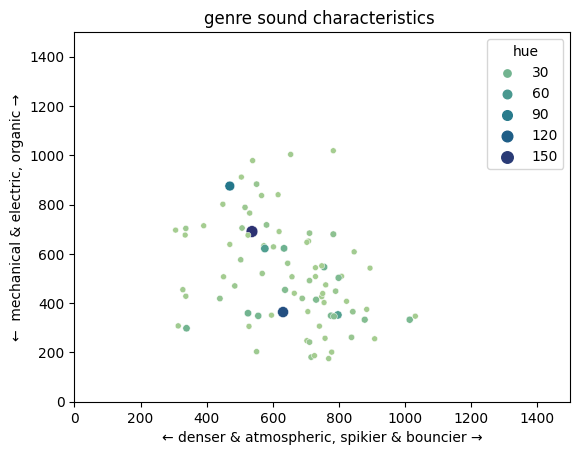

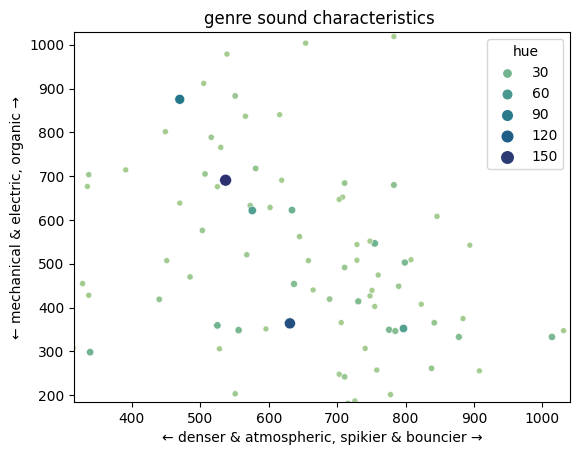

p value is 4.320510451688916e-50
[[407.58868648 195.41131352]
 [297.41131352 142.58868648]]
Dependent (reject H0)
electric


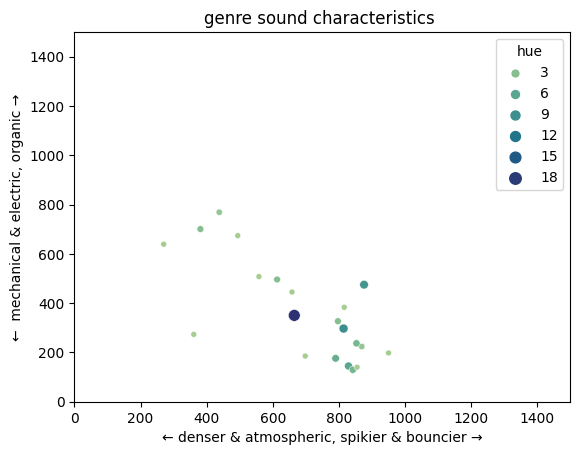

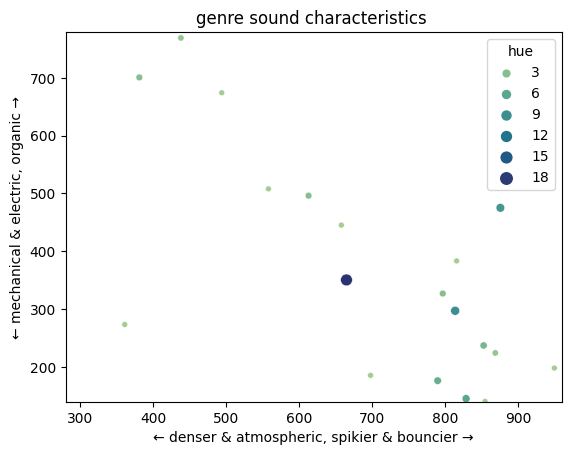

p value is 3.92344199526948e-08
[[ 9.03896104 48.96103896]
 [ 2.96103896 16.03896104]]
Dependent (reject H0)
indie


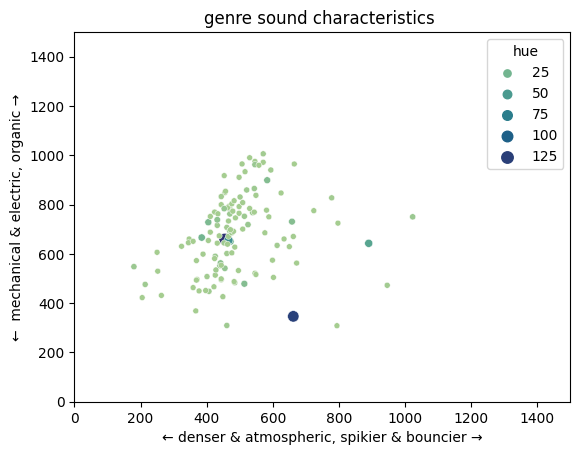

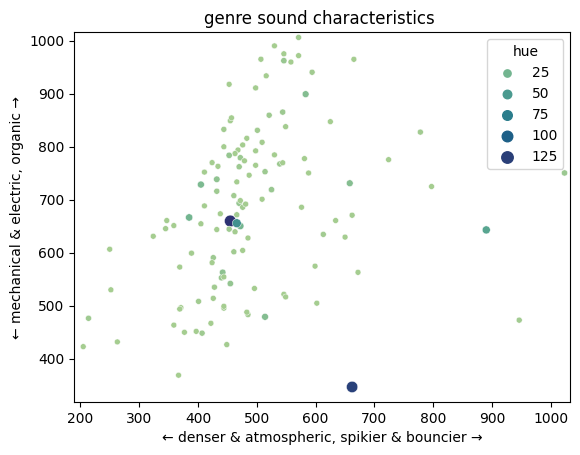

p value is 6.217528428121154e-06
[[393.05898123 147.94101877]
 [148.94101877  56.05898123]]
Dependent (reject H0)
folk


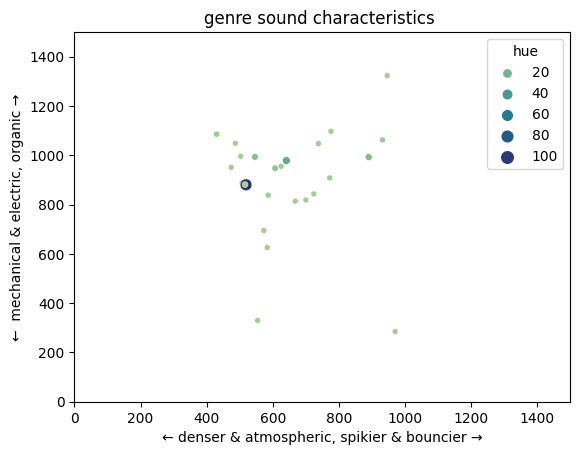

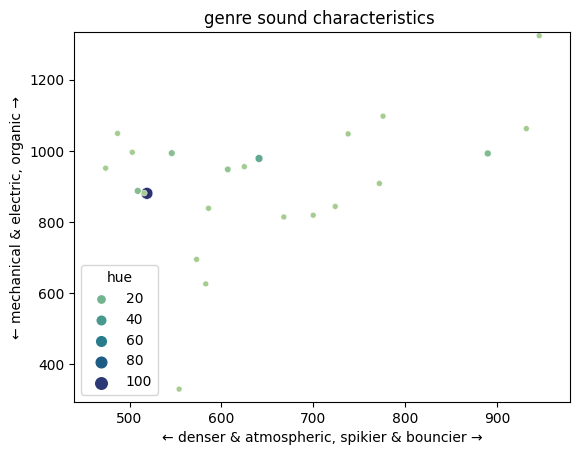

p value is 1.0
[[  4.41463415   0.58536585]
 [176.58536585  23.41463415]]
Independent (H0 holds true)
rock


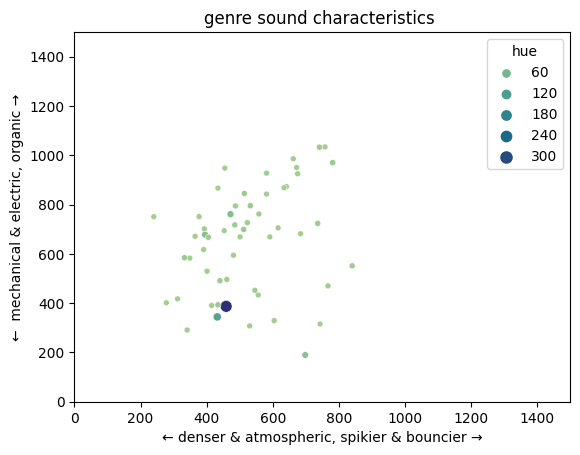

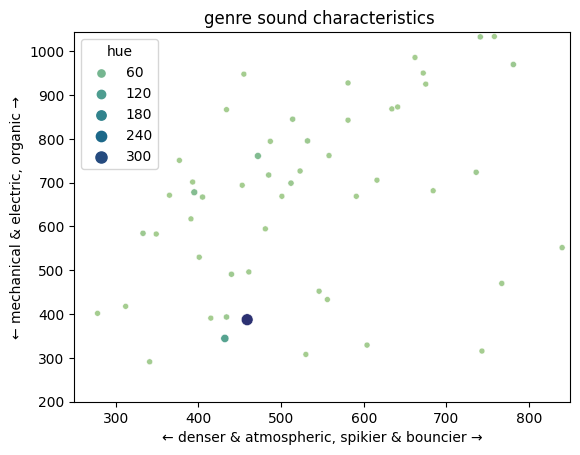

p value is 2.291077326640875e-09
[[486.99354839  78.00645161]
 [181.00645161  28.99354839]]
Dependent (reject H0)
alt


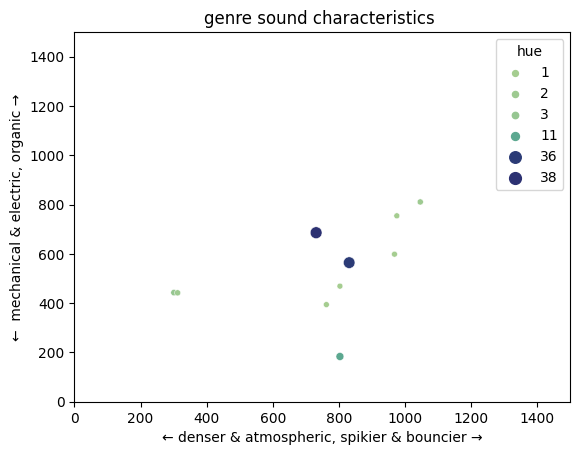

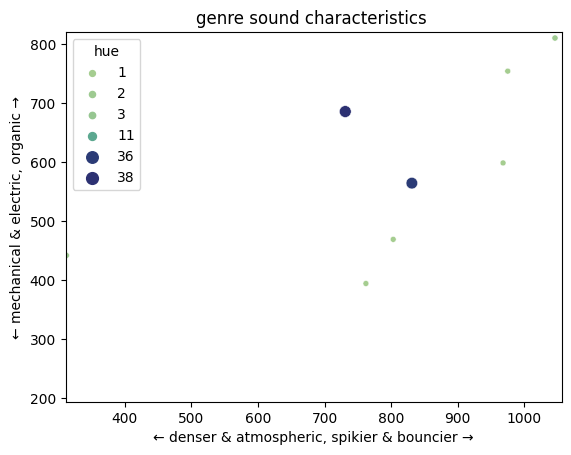

p value is 2.7590413978429873e-05
[[ 0.9375 17.0625]
 [ 4.0625 73.9375]]
Dependent (reject H0)
dance


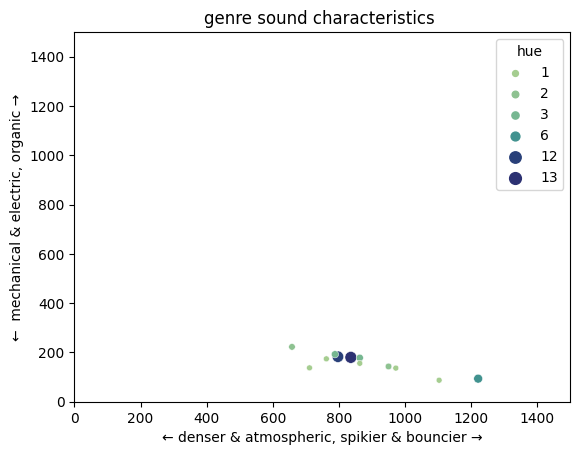

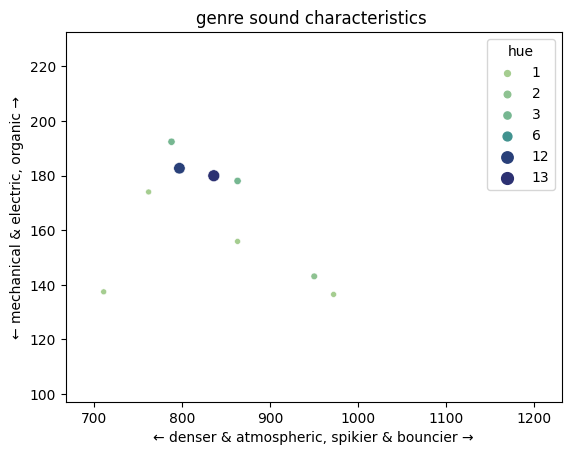

p value is 2.0241747565270176e-08
[[ 9.39130435  2.60869565]
 [26.60869565  7.39130435]]
Dependent (reject H0)
hip hop


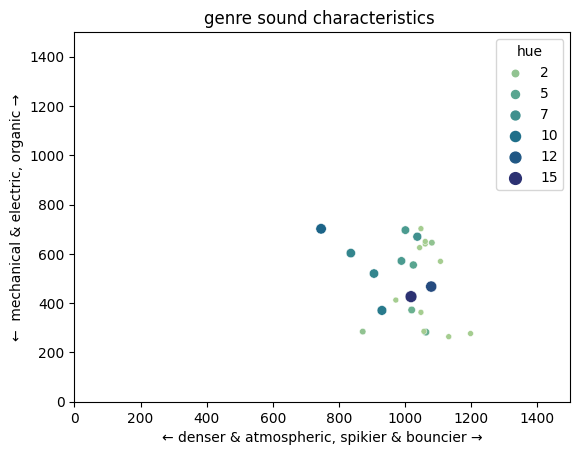

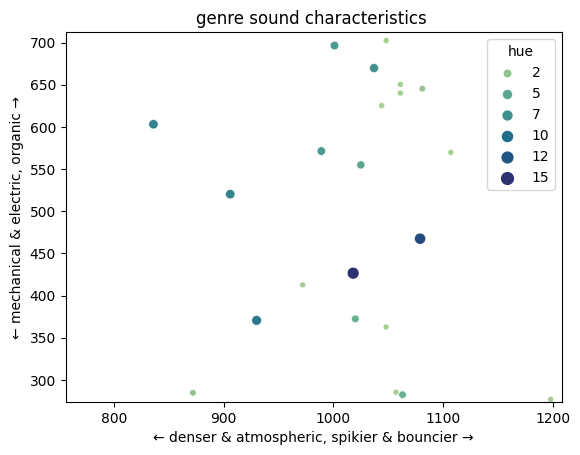

p value is 0.017792278157856656
[[18.43636364 33.56363636]
 [20.56363636 37.43636364]]
Dependent (reject H0)
r&b


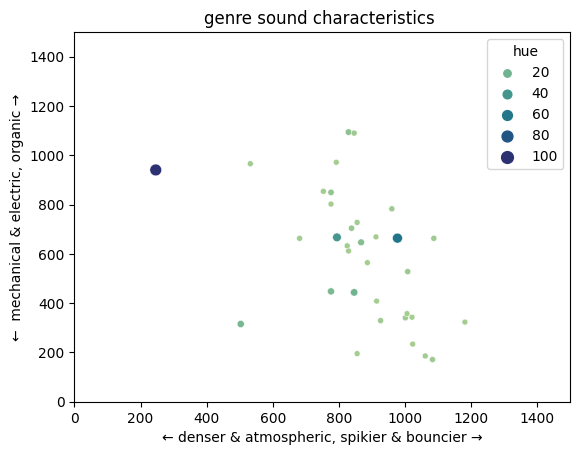

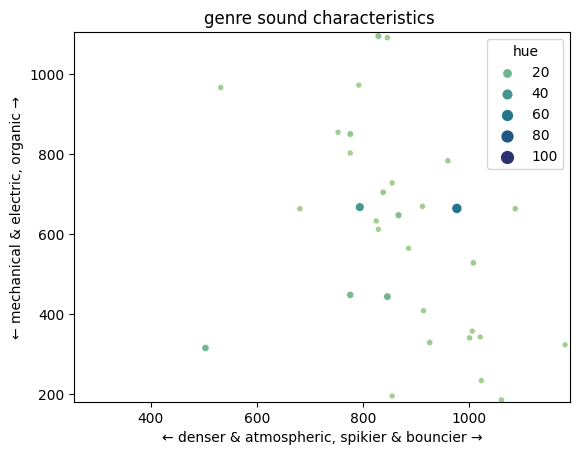

p value is 0.0032899521063684666
[[ 28.42771084  49.57228916]
 [ 92.57228916 161.42771084]]
Dependent (reject H0)
rap


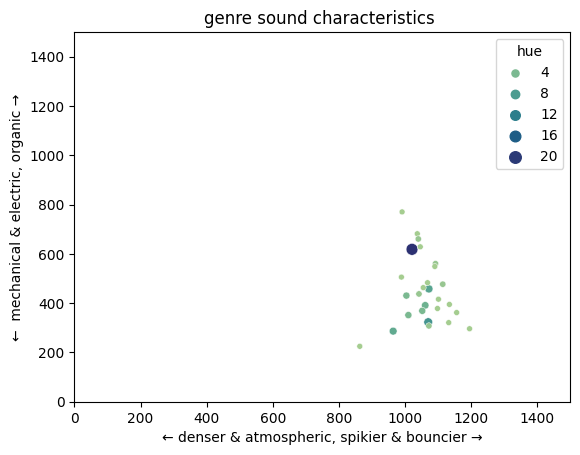

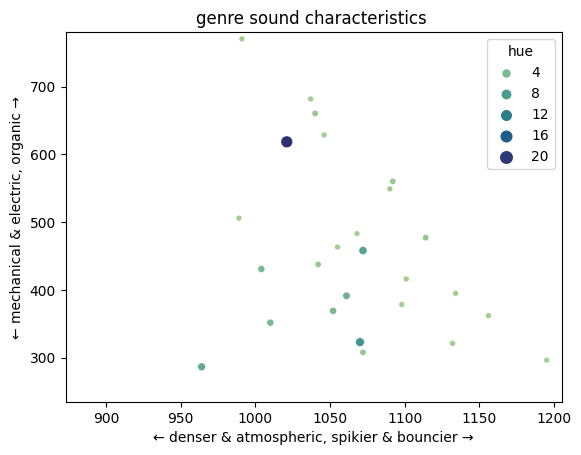

p value is 3.213416902291949e-05
[[25.53571429 29.46428571]
 [13.46428571 15.53571429]]
Dependent (reject H0)
punk


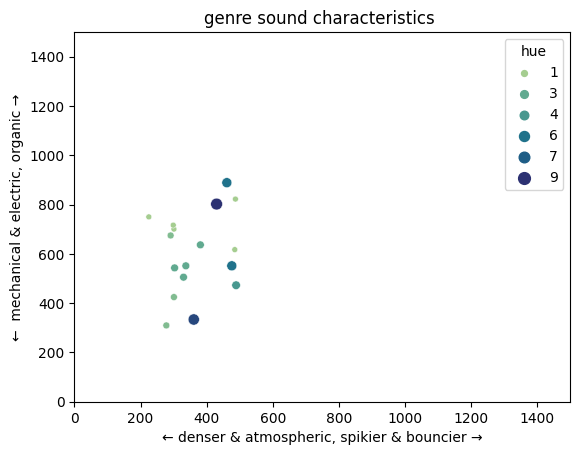

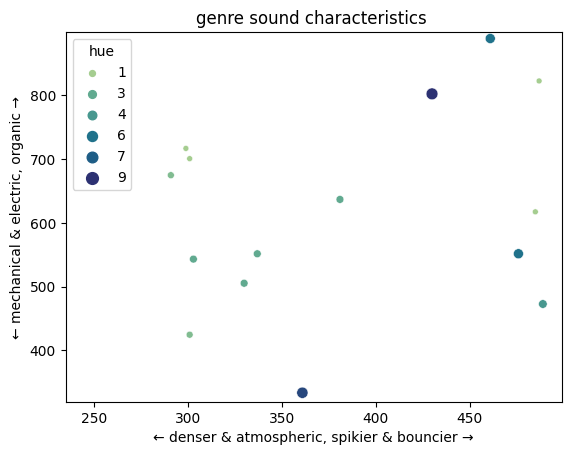

p value is 0.00099579165388109
[[14.39285714 16.60714286]
 [11.60714286 13.39285714]]
Dependent (reject H0)
classical


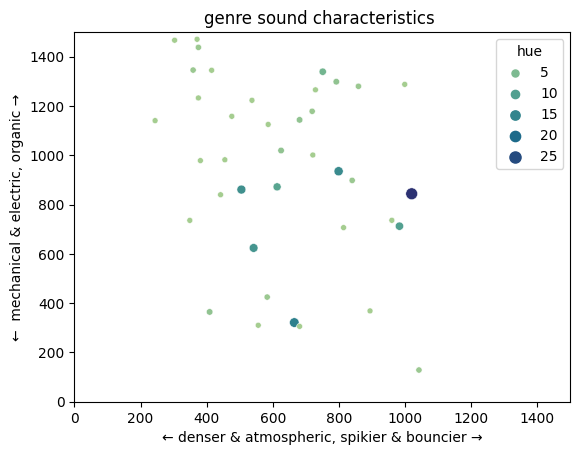

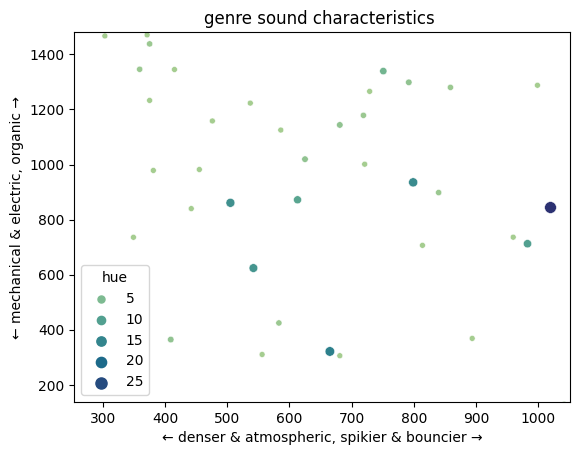

p value is 1.0
[[19.41290323 31.58709677]
 [39.58709677 64.41290323]]
Independent (H0 holds true)


In [ ]:
for parent in cg:
  print(parent)
  gimmeTheRunDown(parent)

